### GOES and AIA flare catalog production - Goal 3
This notebook contains some sample code to load up the AIA flare catalog, extract the entries which do not have an associated M/X GOES flare, and then plots the corresponding peak in each AIA channel along with markers for the start, peak and end times. You'll want to also have a copy of the catalog open so that you can make edits to it as needed. As you get accustomed to the data, it may be easier to transfer this code to a script, plot all of the peaks and then go through the generated plots one by one. 

In [1]:
## import packages
import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
from datetime import datetime,timedelta
from helper import *

In [2]:
## load the AIA flare catalog 
flares = pd.read_csv('aia_flares_catalog_7_pred.csv')
lams = ['193','171','304','1600','131','94']
aia_dir = '/srv/data/sdo_sharps/aia_timeseries/' # might need to change this to the path to the aia timeseries data

# convert all time columns to datetime objects
flares['aia_max_start_time'] = pd.to_datetime(flares['aia_max_start_time'])
flares['aia_min_end_time'] = pd.to_datetime(flares['aia_min_end_time'])
flares['goes_start_time'] = pd.to_datetime(flares['goes_start_time'])
flares['goes_end_time'] = pd.to_datetime(flares['goes_end_time'])
for lam in lams:
    flares[lam+'_start_time'] = pd.to_datetime(flares[lam+'_start_time'])
    flares[lam+'_peak_time'] = pd.to_datetime(flares[lam+'_peak_time'])
    flares[lam+'_end_time'] = pd.to_datetime(flares[lam+'_end_time'])

flares['mean_start_time']  = flares['aia_max_start_time']+flares[[lam+'_start_time'for lam in lams]].subtract(flares['aia_max_start_time'],axis=0).mean(axis=1)
flares['mean_peak_time']  = flares['aia_max_start_time']+flares[[lam+'_peak_time'for lam in lams]].subtract(flares['aia_max_start_time'],axis=0).mean(axis=1)
flares['mean_end_time']  = flares['aia_max_start_time']+flares[[lam+'_end_time'for lam in lams]].subtract(flares['aia_max_start_time'],axis=0).mean(axis=1)

# filter only events with associated GOES flare entry
flares_nogoes = flares[flares['goes_flare_ind'].isnull()]
# filter only M/X flares as given by GOES
flares_nogoes = flares_nogoes[np.logical_or(flares_nogoes['ert_pred_CMX']=='M',flares_nogoes['ert_pred_CMX']=='X')]
print(len(flares_nogoes),'flares in the AIA catalog without GOES labels, but estimated M/X magnitude')


202 flares in the AIA catalog without GOES labels, but estimated M/X magnitude


In [ ]:
## loop through the catalog and plot event
#i=np.arange(0,330) #there are 330 flares in the catalogue (index 0-329)
for i in range(len(flares_nogoes)):
    flare = flares_nogoes.iloc[i]
# load AIA timeseries data
    with open(aia_dir+'sharp_'+str(flare['SHARP'])+'_aia_sum_intensity', "rb") as fp:   #Pickling
        aia_data = pickle.load(fp)
    with open(aia_dir+'sharp_'+str(flare['SHARP'])+'_aia_times', "rb") as fp:   #Pickling
        aia_times = pickle.load(fp)

    plot_flare(flare,aia_times,aia_data,window=60);
    output_filename = f'timeseries_data/plot-{i}.png'
    plt.savefig(output_filename) #save figures to directory
    plt.close('all')
# break


No handles with labels found to put in legend.


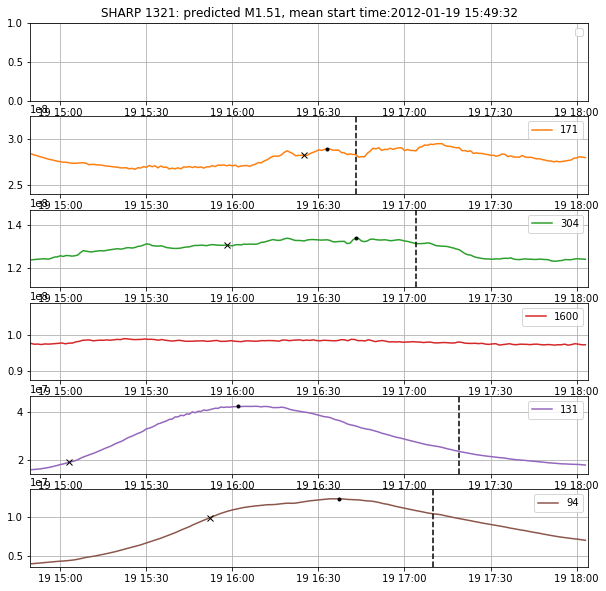

In [5]:
i = 2
flare = flares_nogoes.iloc[i]
# load AIA timeseries data
with open(aia_dir+'sharp_'+str(flare['SHARP'])+'_aia_sum_intensity', "rb") as fp:   #Pickling
    aia_data = pickle.load(fp)
with open(aia_dir+'sharp_'+str(flare['SHARP'])+'_aia_times', "rb") as fp:   #Pickling
    aia_times = pickle.load(fp)

plot_flare_nogoes(flare,aia_times,aia_data,window=60);
# output_filename = f'timeseries_data/plot-{i}.png'
# plt.savefig(output_filename, facecolor = 'white') #save figures to directory
# plt.close('all')

After correcting the timing of the flares, we would also like to verify them using video data and checking against the Solar Monitor catalog. I'm not sure the most efficient way to do this -- you probably want to do all the timing and catalog clean-up first and then go through and verify, but maybe you want to do it flare by flare. Basically you should check Solar Monitor to see if there is any record of a flare at the given time in that active region (might need to check the nonempty_sharps_with_noaa_ar.csv file for the AR). If there is an entry on Solar Monitor, you can add the magnitude and start time from Solar Monitor in place of the GOES information in the catalog. Otherwise you can look at a movie of the SHARP and see if it looks like a flare. This will be the most ambiguous part, but you've seen some movies of flares now so you should have some idea. The movies are currently being generated. To download all the movies to your local computer to view them, you can run this command (after replacing with your username):

scp kiva6588@deepviz.int.colorado.edu:/srv/data/sdo_sharps/hdf5_processed/aia_131/\*/*.mov